In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import numpy as np
from matplotlib import cm
import geopandas
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import requests
from bs4 import BeautifulSoup
from IPython.core.display import HTML

In [2]:
sns.set()

In [3]:
complaints=pd.read_csv('ppd_complaints.csv')

In [4]:
complaint_date=complaints.reset_index().set_index('complaint_id')['date_received'].to_dict()

In [5]:
po_districts=geopandas.read_file("Boundaries_District.geojson")
po_districts.head(5)

OBJECTID  AREA     PERIMETER  DISTRICT_ DISTRICT_ID  DIST_NUM SUM_AREA  \
0       321  None  81903.641825          1        None         1     None   
1       322  None  63587.369399          2        None         2     None   
2       323  None  55305.496227          3        None         3     None   
3       324  None  71919.797243          5        None         5     None   
4       325  None  34655.320856          6        None         6     None   

  DIST_NUMC                      LOCATION     PHONE DIV_CODE     AREA_SQMI  \
0        01           24th St. & Wolf St.  686-3010      SPD  2.163501e+08   
1        02    Harbison Ave. & Levick St.  686-3020     NEPD  1.923461e+08   
2        03        11th St. & Wharton St.  686-3030      SPD  1.839049e+08   
3        05  Ridge Ave. & Cinnaminson St.  686-3050     NWPD  2.130442e+08   
4        06         11th St. & Winter St.  686-3060      CPD  6.927927e+07   

                                            geometry  
0  POLYGON ((-75.19724 39.92944, -75.19693 39.929...  
1  POLYGON ((-75.05444 40.04454, -75.05482 40.044...  
2  POLYGON ((-75.13205 39.89932, -75.13470 39.894...  
3  POLYGON ((-75.20430 40.03468, -75.20403 40.034...  
4  POLYGON ((-75.13437 39.95294, -75.13524 39.950...

In [6]:
disciplines=pd.read_csv('ppd_complaint_disciplines.csv')

In [7]:
disciplines['date_recieved']=disciplines.complaint_id.map(complaint_date)

In [8]:
disciplines['district_num']=pd.to_numeric(disciplines.po_assigned_unit.dropna().apply(lambda x: x.split(' ')[0][:2]),errors='coerce')

In [9]:
inc=geopandas.read_file("../incidents_part1_part2.geojson")

In [10]:
complaintsbyofficer=disciplines.groupby('officer_id').complaint_id.count().sort_values(ascending=False)

In [11]:
complaintsbyofficer.describe().to_frame().style.format("{:.2f}")

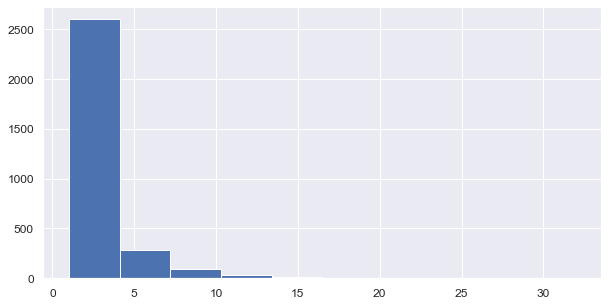

In [12]:
fig, ax = plt.subplots(1, 1,figsize=(10,5))
complaintsbyofficer.hist(figsize=(10,5));
ax.tick_params(labelsize=12)

In [13]:
unit_officer=disciplines.groupby(['po_assigned_unit','officer_id']).complaint_id.count().reset_index()

In [14]:
disciplines[disciplines['officer_id']==29180642].head(10)

complaint_id  officer_id po_race po_sex    po_assigned_unit  \
1813      16-0176  29180642.0   black   male  3500 35TH DISTRICT   
1814      16-0176  29180642.0   black   male  3500 35TH DISTRICT   
1939      16-0224  29180642.0   black   male  3500 35TH DISTRICT   
2104      16-0282  29180642.0   black   male  3500 35TH DISTRICT   
2441      16-0439  29180642.0   black   male  3500 35TH DISTRICT   
2443      16-0439  29180642.0   black   male  3500 35TH DISTRICT   
2444      16-0439  29180642.0   black   male  3500 35TH DISTRICT   
2445      16-0439  29180642.0   black   male  3500 35TH DISTRICT   
4346      17-0557  29180642.0   black   male  3500 35TH DISTRICT   
4347      17-0557  29180642.0   black   male  3500 35TH DISTRICT   

     allegations_investigated investigative_findings disciplinary_findings  \
1813   Departmental Violation  No Sustained Findings        Not Applicable   
1814   Unprofessional Conduct  No Sustained Findings        Not Applicable   
1939               Harassment  No Sustained Findings        Not Applicable   
2104             Verbal Abuse  No Sustained Findings        Not Applicable   
2441             Verbal Abuse  No Sustained Findings        Not Applicable   
2443   Departmental Violation      Sustained Finding   Training/Counseling   
2444   Departmental Violation      Sustained Finding   Training/Counseling   
2445   Departmental Violation  No Sustained Findings        Not Applicable   
4346   Departmental Violation  No Sustained Findings        Not Applicable   
4347   Departmental Violation      Sustained Finding        Guilty Finding   

     date_recieved  district_num  
1813    2016-04-07          35.0  
1814    2016-04-07          35.0  
1939    2016-05-05          35.0  
2104    2016-06-15          35.0  
2441    2016-09-15          35.0  
2443    2016-09-15          35.0  
2444    2016-09-15          35.0  
2445    2016-09-15          35.0  
4346    2017-11-03          35.0  
4347    2017-11-03          35.0

In [15]:
unit_officer=disciplines.groupby(['district_num','officer_id']).complaint_id.count().reset_index()

In [16]:
display(HTML('<h1>TOP 10 OFFICERS BY NUMBER OF COMPLAINTS</h1>'))
unit_officer[unit_officer['district_num'].isin(po_districts.DISTRICT_.unique())].sort_values('complaint_id',ascending=False).head(10).style.hide_index()

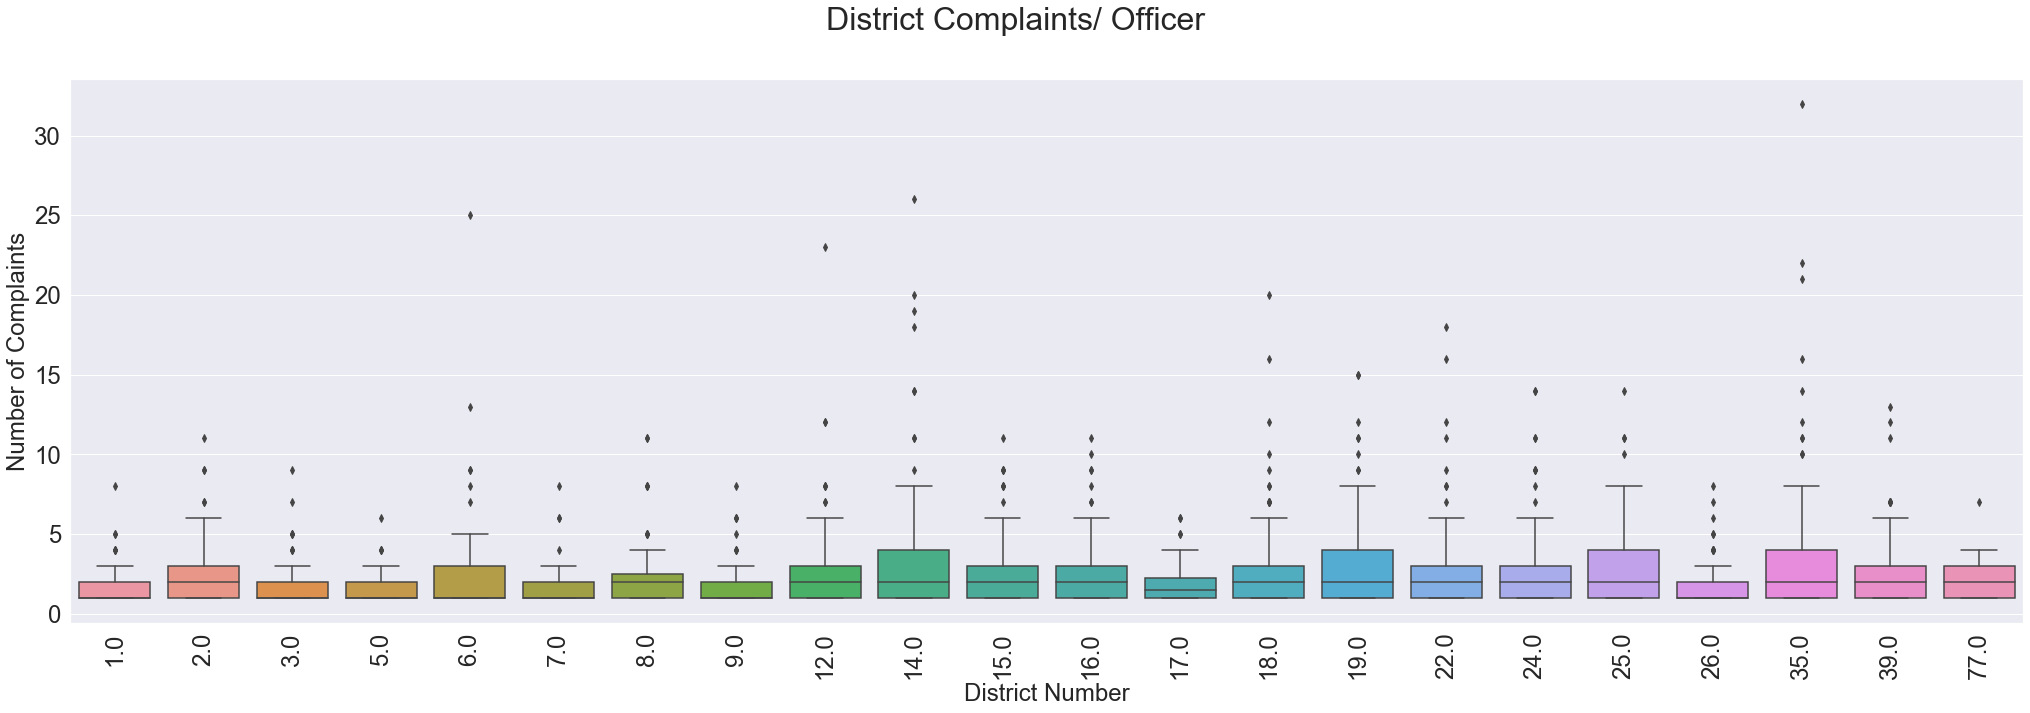

In [17]:
fig, ax = plt.subplots(1, 1,figsize=(35,10))
g=sns.boxplot(x="district_num", y="complaint_id",data=unit_officer[unit_officer['district_num'].isin(po_districts.DISTRICT_.unique())], ax=ax)
plt.xticks(rotation=90);
ax.tick_params(labelsize=24);
fig.suptitle('District Complaints/ Officer', fontsize=32);
ax.set_xlabel('District Number', fontsize=24);
ax.set_ylabel('Number of Complaints', fontsize=24);

In [18]:
outlier_officers=[]
for c, g in unit_officer.reset_index().groupby('district_num'):
    stats=boxplot_stats(g.complaint_id)
    outliers = [y for stat in boxplot_stats(g['complaint_id']) for y in stat['fliers']]
    outlier_officers=np.append(outlier_officers,list(g[g['complaint_id'].isin(outliers)].officer_id.values))

In [19]:
outlier_officers

array([10313341., 40951463., 52393037., 56882326., 58245660., 59603158.,
       95898897., 14056589., 31104623., 60742990., 86291696., 95972711.,
       22288095., 30683023., 36215669., 42237550., 51476365., 53566343.,
       95869027., 96776430., 39608728., 43164178., 48582841., 90665971.,
       26171762., 45215188., 50265123., 65283090., 73464815., 95949708.,
       28059007., 51583482., 57672311., 62882234., 12261697., 16598894.,
       22282258., 30096971., 32476884., 34885637., 37365800., 38033563.,
       57849466., 33940469., 46690103., 55591432., 66277696., 72571489.,
       88349229., 91900216., 93460275., 23729879., 47490388., 51562883.,
       53656122., 66221391., 68604909., 75318757., 85068952., 15885297.,
       19128839., 23622762., 31467344., 35134546., 40251428., 47524892.,
       60319330., 71848451., 29770128., 43894426., 51762010., 58419553.,
       60290490., 71514570., 95329152., 97023965., 11386739., 14563505.,
       16850206., 19466153., 71412088., 73690721., 

In [20]:
outlier_race=disciplines[disciplines['officer_id'].isin(outlier_officers)].groupby('officer_id')['po_race'].unique()

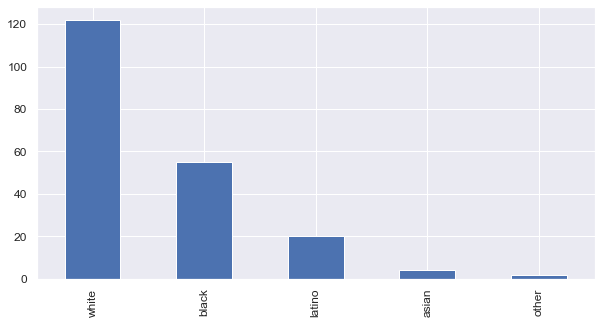

In [21]:
fig, ax = plt.subplots(1, 1,figsize=(10,5))
outlier_race.apply(lambda x:x[0]).value_counts().plot(kind='bar', ax=ax);
ax.tick_params(labelsize=12)

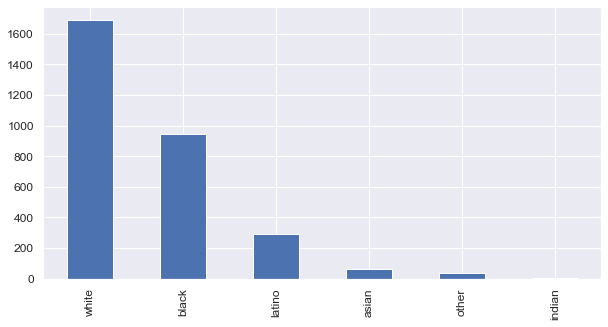

In [22]:
fig, ax = plt.subplots(1, 1,figsize=(10,5))
disciplines.groupby('officer_id').po_race.unique().apply(lambda x:x[0]).value_counts().plot(kind='bar');
ax.tick_params(labelsize=12)

In [23]:
colors_tc=cm.Spectral(np.linspace(0, 1,len(disciplines.investigative_findings.unique()) ) )

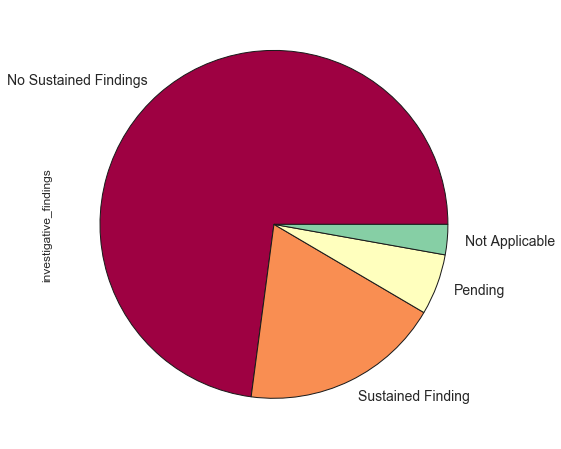

In [24]:
fig, ax = plt.subplots(1, 1,figsize=(8,8))
disciplines.investigative_findings.value_counts().plot(kind='pie', ax=ax,textprops={'fontsize': 14},colors=colors_tc,wedgeprops={"edgecolor":"k",'linewidth': 1, 'antialiased': True});

In [25]:
race_results=disciplines.groupby('po_race').investigative_findings.value_counts().to_frame()
race_results.columns=['counts']
race_results=race_results.reset_index()
r_f=race_results[~race_results.investigative_findings.isin(['Pending'])]

In [26]:

cdict={}
for i,c in zip(disciplines.investigative_findings.unique(), colors_tc):
    cdict[i]=c

def plt_pie(x,y,**kwargs):
    cd=[cdict[l] for l in x] 
    plt.pie(y,labels=x, colors=cd,wedgeprops={"edgecolor":"k",'linewidth': 1, 'antialiased': True})

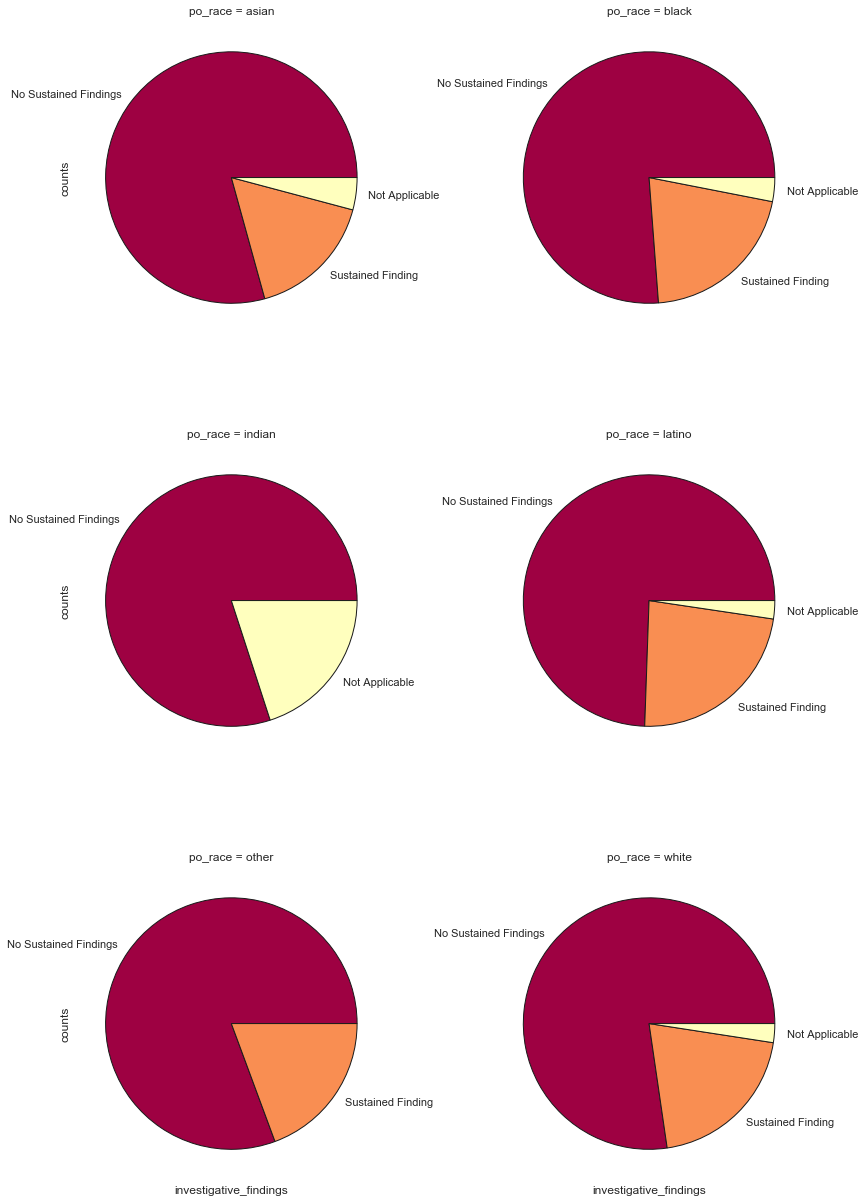

In [27]:
g=sns.FacetGrid(r_f,col="po_race", col_wrap=2, sharey=False,height=6)
g=(g.map(plt_pie, "investigative_findings", "counts",cdict=cdict))

In [28]:
pd.pivot_table(r_f,values='counts',index=['po_race'],columns=['investigative_findings']).apply(lambda x: x / x.sum(), axis=1).fillna(0).style.format("{:.2%}")

In [29]:
ps=geopandas.read_file("Police_Stations.geojson")

In [30]:
comp_dict=disciplines.groupby('district_num').complaint_id.count().to_dict()

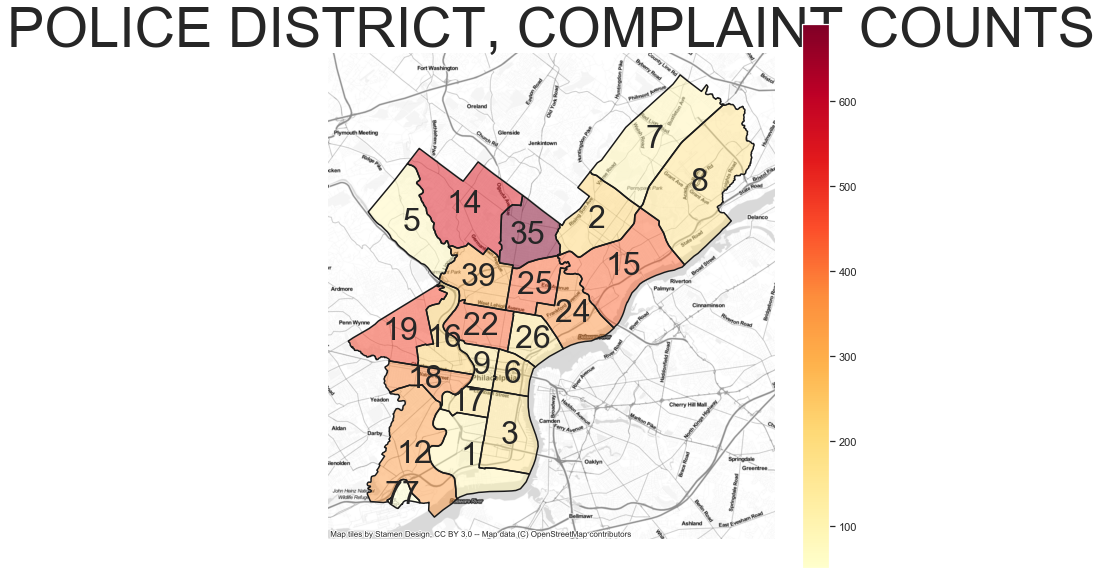

In [31]:
po_districts['comp_count']=pd.to_numeric(po_districts.DISTRICT_).apply(lambda x: comp_dict[x])

fig, ax = plt.subplots(1, 1,figsize=(10,10))
po_districts.to_crs(epsg=3857).plot(column='comp_count',cmap='YlOrRd',legend=True, ax=ax, alpha=0.5)
po_districts.to_crs(epsg=3857).boundary.plot(ax=ax, color='k')
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

for l,name in zip(po_districts.to_crs(epsg=3857).centroid,po_districts.DISTRICT_):
    plt.text(l.x,l.y,name,ha='center', va='center',fontsize='32')
    
ax.set_axis_off()
ax.set_title('POLICE DISTRICT, COMPLAINT COUNTS',fontsize='56');

In [32]:
outliers_dict=disciplines[disciplines['officer_id'].isin(outlier_officers)].groupby('district_num').complaint_id.count().to_dict()

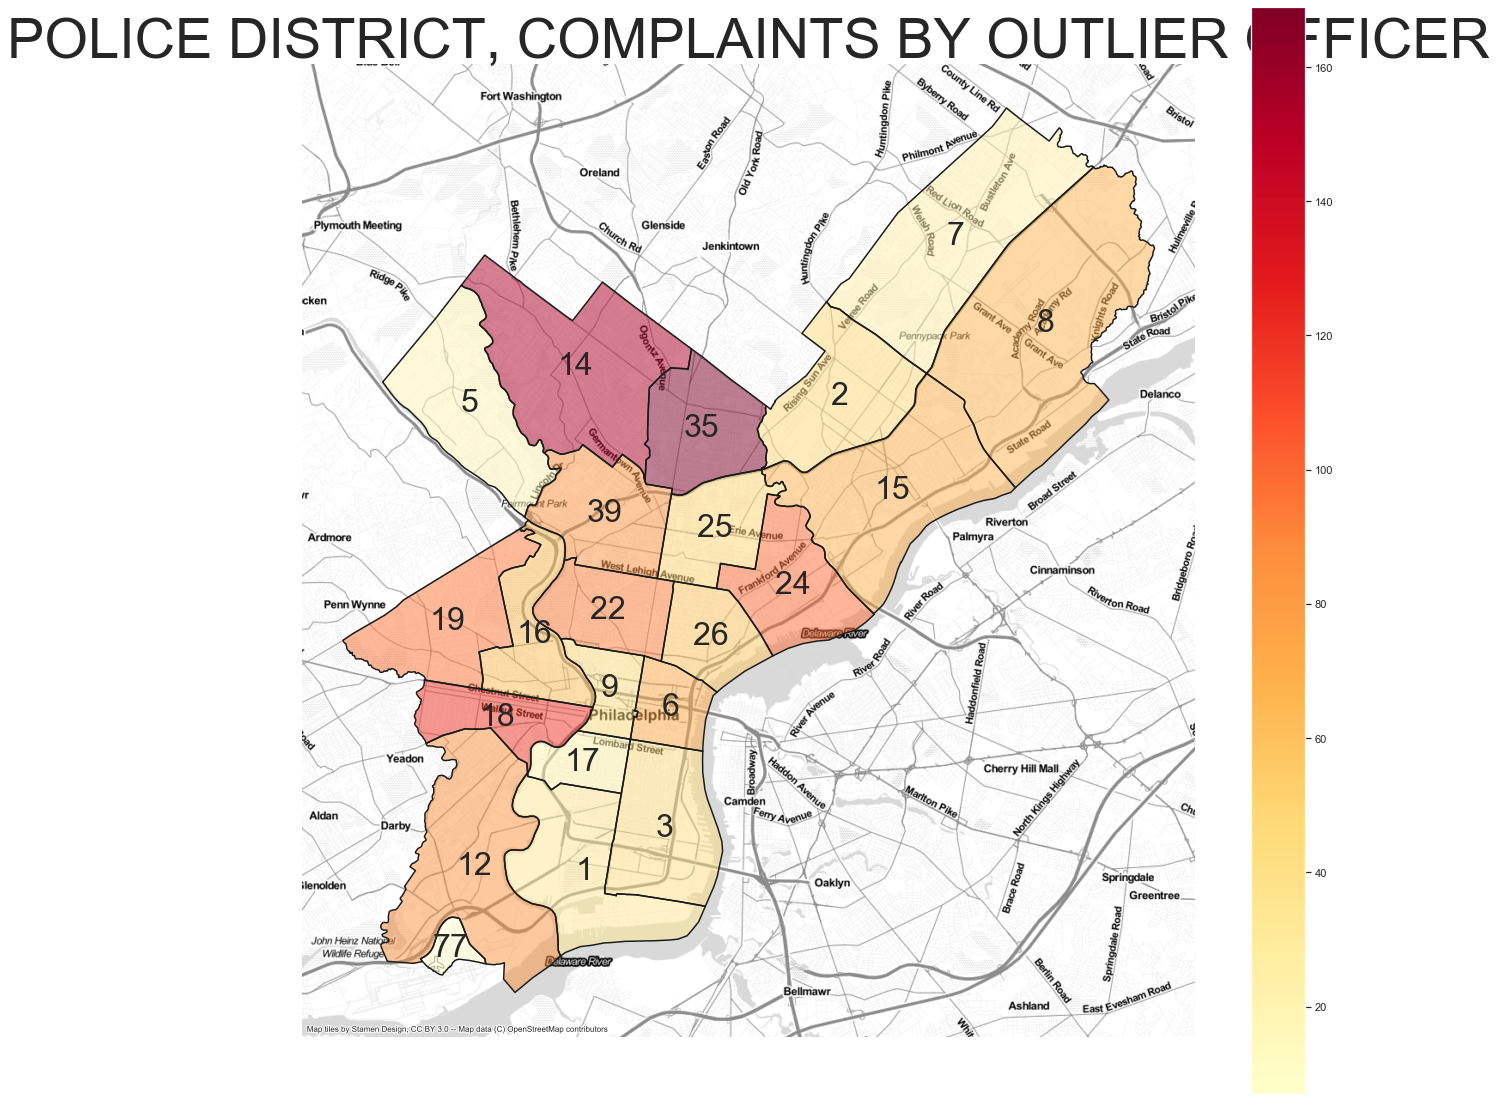

In [86]:
po_districts['outlier_count']=pd.to_numeric(po_districts.DISTRICT_).apply(lambda x: outliers_dict[x])

fig, ax = plt.subplots(1, 1,figsize=(20,20))
po_districts.to_crs(epsg=3857).plot(column='outlier_count',cmap='YlOrRd',legend=True, ax=ax, alpha=0.5)
po_districts.to_crs(epsg=3857).boundary.plot(ax=ax, color='k')
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
for l,name in zip(po_districts.to_crs(epsg=3857).centroid,po_districts.DISTRICT_):
    plt.text(l.x,l.y,name,ha='center', va='center',fontsize='32')
ax.set_axis_off()
ax.set_title('POLICE DISTRICT, COMPLAINTS BY OUTLIER OFFICER',fontsize='56');

In [34]:
inc_in_z=geopandas.sjoin(inc,po_districts,how='inner',op='within')

In [35]:
inc_in_d=inc_in_z.groupby('DISTRICT_').objectid.count()

In [36]:
inc_in_d_dict=inc_in_d.to_dict()

In [37]:
po_districts['incidents']=po_districts['DISTRICT_'].apply(lambda x: inc_in_d_dict[x])

In [38]:
po_districts['ratio']=po_districts.apply(lambda x:(x.comp_count*1000)/x.incidents,axis=1)

In [39]:
ratio_dict=po_districts[['DISTRICT_','ratio']].set_index('DISTRICT_').to_dict()['ratio']

In [40]:
inc_in_d=inc_in_d.loc[lambda x: x.index != 77]

In [41]:
xmax=inc_in_d.max()
xmin=inc_in_d.min()

def scale_into_range(x,a,b,xmin,xmax):
    res=(((b-a)*(x-xmin))/(xmax-xmin))+a
    return res

inc_in_d_scale=inc_in_d.apply(lambda x: scale_into_range(x,1000,20000,xmin,xmax))
inc_in_d_scale_dict=inc_in_d_scale.to_dict()



In [42]:
po_districts_n=po_districts[po_districts['DISTRICT_']!=77].copy()
po_districts_n['Inc_Sc']=po_districts_n.DISTRICT_.map(inc_in_d_scale)

Text(0.5, 1, 'POLICE DISTRICT, RATIO OF COMPLAINTS PER 1000 INCIDENTS')

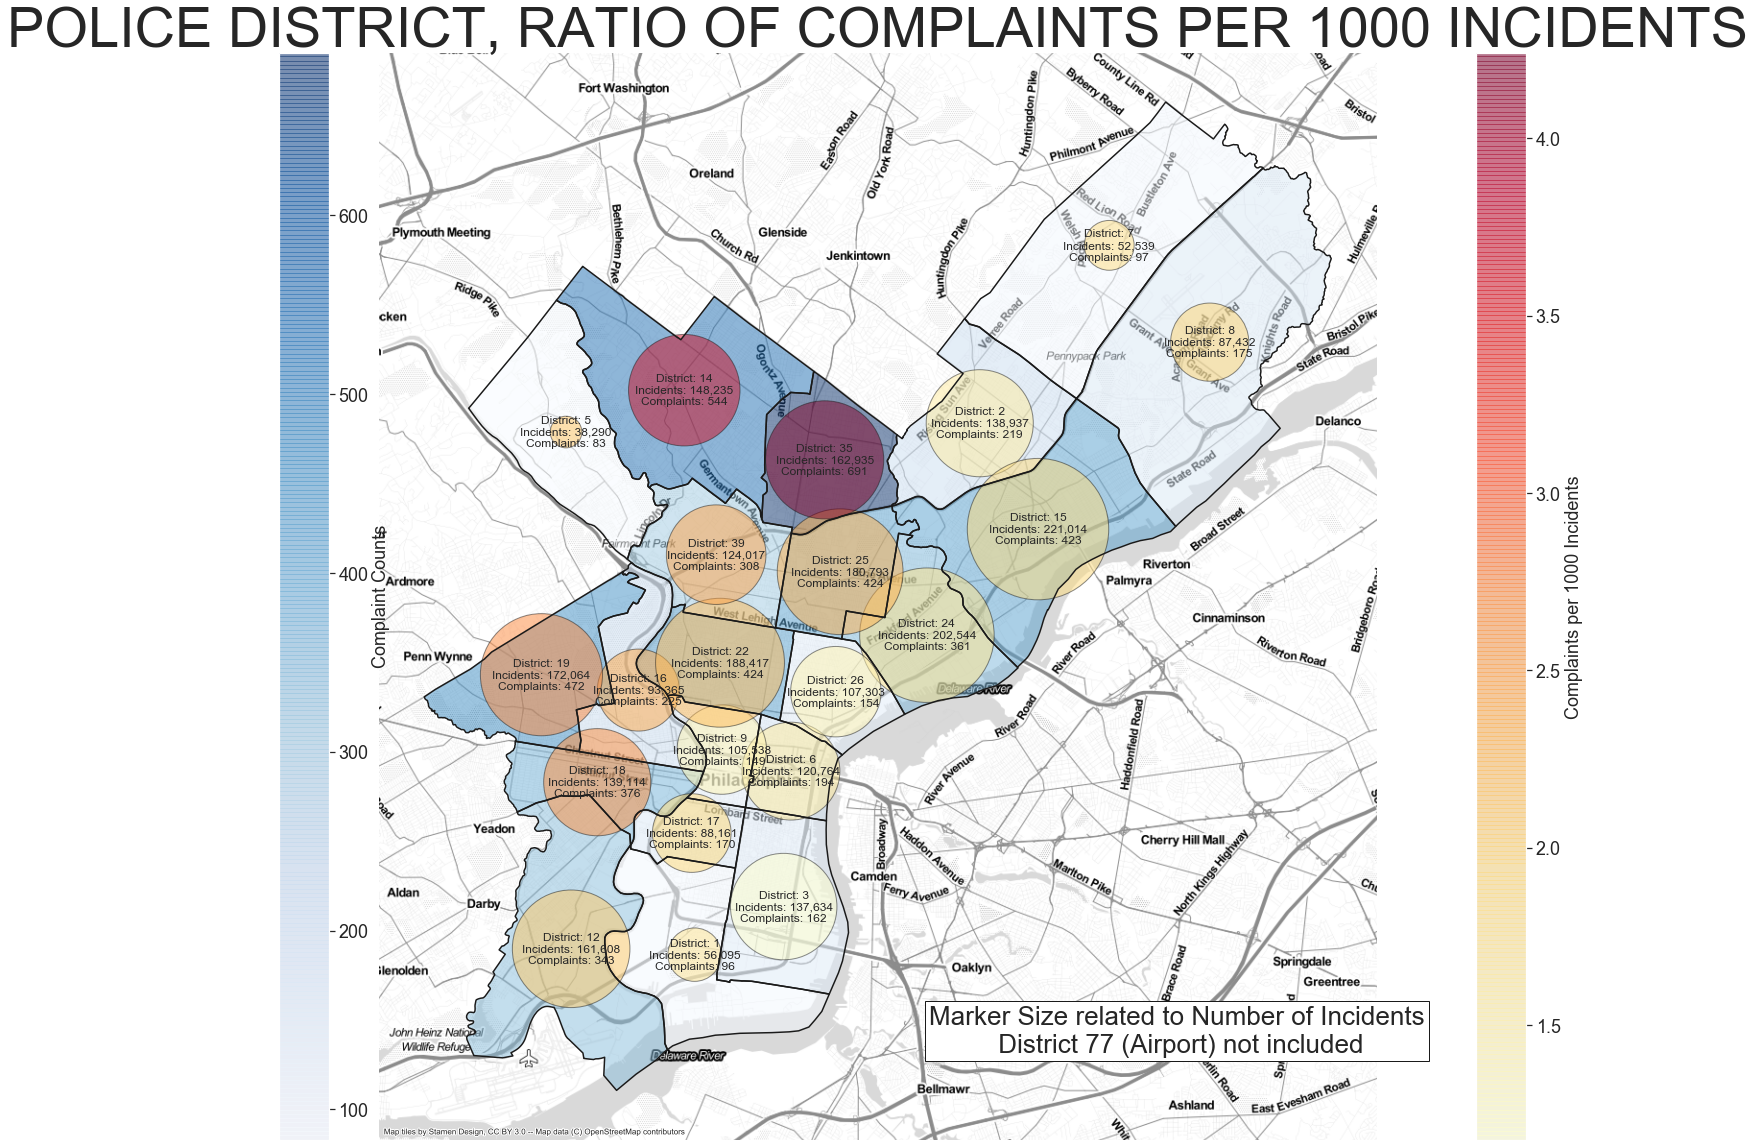

In [87]:
po_districts_n['comp_count']=pd.to_numeric(po_districts_n.DISTRICT_).apply(lambda x: comp_dict[x])

fig, ax = plt.subplots(1, 1,figsize=(20,20))
po_districts_n.to_crs(epsg=3857).plot(column='comp_count',cmap='Blues', ax=ax, alpha=0.5)

po_districts_n.to_crs(epsg=3857).boundary.plot(ax=ax, color='k')
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
plt.scatter(list(po_districts_n.to_crs(epsg=3857).centroid.x),list(po_districts_n.to_crs(epsg=3857).centroid.y),alpha=0.5,s=list(po_districts_n.Inc_Sc),c=list(po_districts_n.ratio),cmap='YlOrRd',edgecolor='k')  
for l,name in zip(po_districts_n.to_crs(epsg=3857).centroid,po_districts_n.DISTRICT_):
    mlab='District: '+str(name)+'\nIncidents: '+'{:,}'.format(inc_in_d_dict[name])+'\nComplaints: '+str(comp_dict[name])
    plt.text(l.x,l.y,mlab,ha='center', va='center',fontsize='12')

axins = inset_axes(ax,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(-0.1, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )

sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=po_districts_n.comp_count.min(), vmax=po_districts_n.comp_count.max()))
cbr = fig.colorbar(sm, cax=axins,alpha=0.5)
cbr.ax.tick_params(labelsize=18) 
cbr.set_label(label='Complaint Counts',fontsize=18)

axins = inset_axes(ax,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.1, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )

sm2 = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=po_districts_n.ratio.min(), vmax=po_districts_n.ratio.max()))
cbr2 = fig.colorbar(sm2, cax=axins,alpha=0.5)
cbr2.ax.tick_params(labelsize=18) 
cbr2.set_label(label='Complaints per 1000 Incidents',fontsize=18)

plt.text(0.8, 0.1, 'Marker Size related to Number of Incidents\n District 77 (Airport) not included',fontsize=26, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,bbox={'ec':'k','fc':'w'})
ax.set_axis_off()
ax.set_title('POLICE DISTRICT, RATIO OF COMPLAINTS PER 1000 INCIDENTS',fontsize='56')

In [44]:
dn_results=disciplines.groupby('district_num').investigative_findings.value_counts().to_frame()
dn_results.columns=['counts']
dn_results=dn_results.reset_index()
dn_f=dn_results[~dn_results.investigative_findings.isin(['Pending'])]

In [45]:
display(HTML('<h1>INVESTIGATION RESULTS PER DISTRICT</h1>'))
dn_perc=pd.pivot_table(dn_f,values='counts',index=['district_num'],columns=['investigative_findings']).apply(lambda x: x / x.sum(), axis=1)
dn_perc.loc[po_districts.DISTRICT_.unique()].sort_values('Sustained Finding',ascending=False).style.format("{:.2%}")

In [46]:
display(HTML('<h1>SUSTAINED FINDINGS STATISTICS</h1>'))
dn_perc.loc[po_districts.DISTRICT_.unique()]['Sustained Finding'].describe().to_frame().loc[lambda x:x.index!='count'].style.format("{:.2%}")

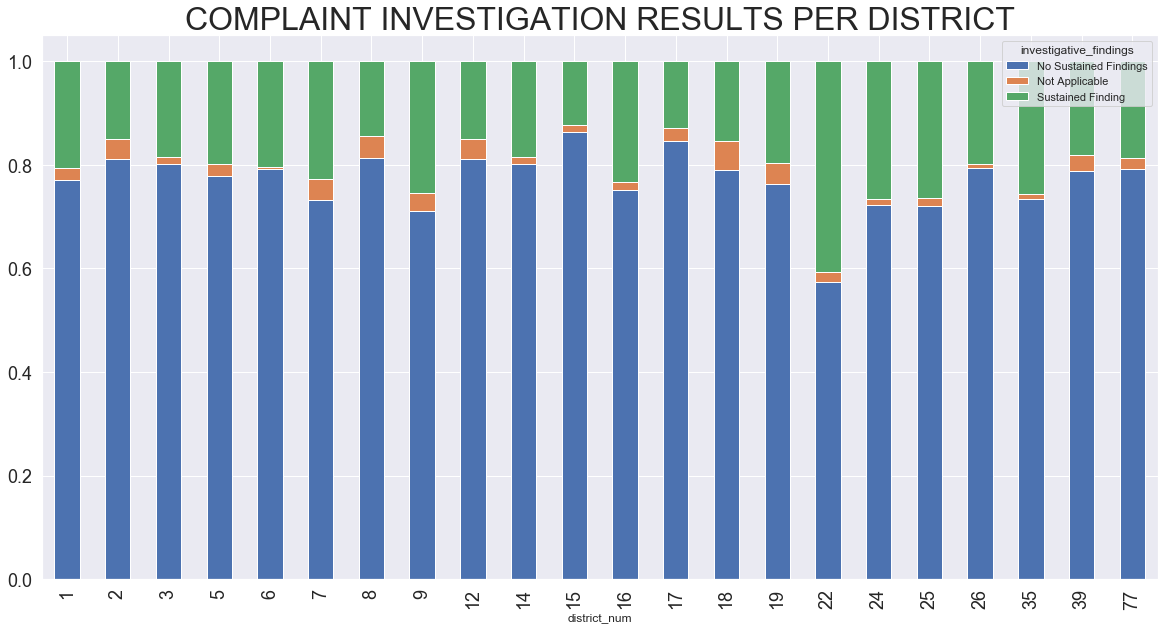

In [88]:
fig, ax = plt.subplots(1, 1,figsize=(10,5))
dn_perc.loc[po_districts.DISTRICT_.unique()].plot(kind='bar',figsize=(20,10),stacked=True,ax=ax);
ax.set_title('COMPLAINT INVESTIGATION RESULTS PER DISTRICT',fontsize='32');
ax.tick_params(labelsize=18)

In [48]:
c_blocks=geopandas.read_file("../Census_Blocks_2010.geojson")

cblocks_in_pd=geopandas.sjoin(c_blocks,po_districts,how='inner',op='intersects')

In [49]:
state_codes=requests.get('https://api.census.gov/data/2010/dec/sf1?get=NAME&for=state:*')

In [50]:
state_dict={}
for x in state_codes.json()[1:]:
    state_dict[x[0]]=x[1]
state_code=state_dict['Pennsylvania']

In [51]:
county_codes=requests.get('https://api.census.gov/data/2010/dec/sf1?get=NAME&for=county:*&in=state:'+state_code)

In [52]:
county_dict={}
for x in county_codes.json()[1:]:
    county_dict[x[0]]=x[2]
county_code=county_dict['Philadelphia County, Pennsylvania']

In [53]:
census_pop=requests.get('https://api.census.gov/data/2018/acs/acs5?get=B00001_001E&for=block%20group:*&in=state:'+state_code+'%20'+'county:'+county_code)

In [54]:
c_bgroup=geopandas.read_file("Census_Block_Groups_2010.geojson")
c_bgroup['bkey']=c_bgroup.TRACTCE10+['|']+c_bgroup.BLKGRPCE10
cbgroups_in_pd=geopandas.sjoin(c_bgroup,po_districts,how='inner',op='intersects')

In [55]:
census_pop_df=pd.DataFrame(census_pop.json()[1:],columns=census_pop.json()[0])

In [56]:
census_race=requests.get('https://api.census.gov/data/2018/acs/acs5?get=group(B02001)&for=block%20group:*&in=state:'+state_code+'%20'+'county:'+county_code)

In [57]:
census_race_df=pd.DataFrame(census_race.json()[1:],columns=census_race.json()[0])

In [58]:
census_vars=requests.get('https://api.census.gov/data/2018/acs/acs5/variables.html')

In [59]:
soup = BeautifulSoup(census_vars.content,'html.parser')

In [60]:
data=[]
table = soup.find('table')
table_body = table.find('tbody')

rows = table_body.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele]) # Get rid of empty values

In [61]:
var_dict=pd.DataFrame(data)[[0,1]].set_index(0).to_dict()[1]

In [62]:
new_cols=[]
for x in census_race_df.columns.values:
    try: 
        val=var_dict[x]
    except:
        val=x
    new_cols.append(val)

In [63]:
census_race_df.columns=new_cols

In [64]:
race_cols_est=['Geography',
'Estimate!!Total',
'Estimate!!Total!!White alone',
'Estimate!!Total!!Black or African American alone',
'Estimate!!Total!!American Indian and Alaska Native alone',
'Estimate!!Total!!Asian alone',
'Estimate!!Total!!Native Hawaiian and Other Pacific Islander alone',
'Estimate!!Total!!Some other race alone',
'Estimate!!Total!!Two or more races',
'Estimate!!Total!!Two or more races!!Two races including Some other race',
'Estimate!!Total!!Two or more races!!Two races excluding Some other race, and three or more races',
'state',
'county',
'tract',
'block group']

In [65]:
census_race_df=census_race_df[race_cols_est].copy()

In [66]:
new_cols=[]
for x in race_cols_est:
    if 'Estimate' in x:
        if len(x.split('!!'))<=2:
            val=x.split('!!')[1]
        else:
            val='-'.join(x.split('!!')[2:])
    else:
        val=x
    new_cols.append(val)

In [67]:
census_race_df.columns=new_cols

In [68]:
census_race_df['bkey']=census_race_df.apply(lambda x: x['tract']+'|'+x['block group'],axis=1)

In [69]:
census_race_df.set_index('bkey',inplace=True)

In [70]:
census_race_df.drop(['Geography','Total','state','county','tract','block group'], axis=1);

In [71]:
cb_div=cbgroups_in_pd.join(census_race_df.drop(['Geography','Total','state','county','tract','block group'], axis=1),on='bkey',how='left')

In [72]:
race_col=['White alone',
'Black or African American alone',
'American Indian and Alaska Native alone', 'Asian alone',
'Native Hawaiian and Other Pacific Islander alone',
'Some other race alone', 'Two or more races', 'Two or more races-Two races including Some other race',
'Two or more races-Two races excluding Some other race, and three or more races']

In [73]:
for c in race_col:
    cb_div[c]=cb_div[c].astype('float');

In [74]:
display(HTML('<h1>DISTRIC RACE PERCENTAGE</h1>'))
district_race_perc=cb_div[['DISTRICT_']+race_col].groupby('DISTRICT_').sum().apply(lambda x: x / x.sum(), axis=1).dropna()
district_race_perc.style.format("{:.2%}")

In [75]:
cats=['White alone','Black or African American alone','Asian alone']
district_race_perc['Other']=district_race_perc.drop(cats,axis=1).sum(axis=1)

In [76]:
white_dict=district_race_perc['White alone'].to_dict()
black_dict=district_race_perc['Black or African American alone'].to_dict()
asian_dict=district_race_perc['Asian alone'].to_dict()
other_dict=district_race_perc['Other'].to_dict()

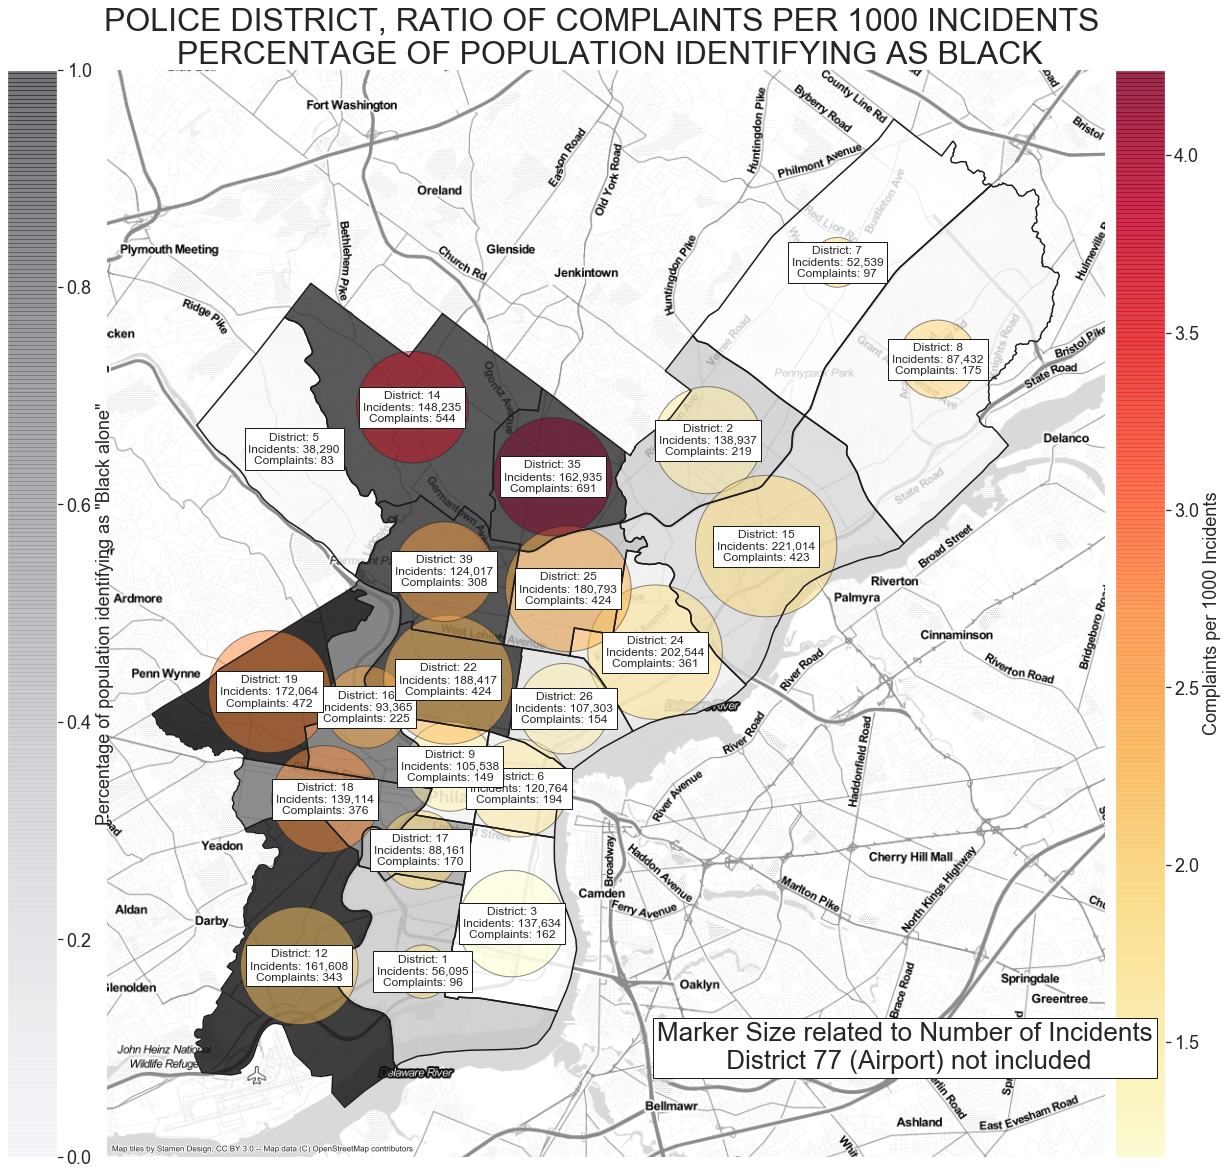

In [89]:
po_districts_n['perc_white']=pd.to_numeric(po_districts_n.DISTRICT_).map(white_dict)
po_districts_n['perc_black']=pd.to_numeric(po_districts_n.DISTRICT_).map(black_dict)
po_districts_n['perc_asian']=pd.to_numeric(po_districts_n.DISTRICT_).map(asian_dict)
po_districts_n['perc_other']=pd.to_numeric(po_districts_n.DISTRICT_).map(other_dict)

fig, ax = plt.subplots(1, 1,figsize=(20,20))
po_districts_n.to_crs(epsg=3857).plot(column='perc_black',cmap='Greys', ax=ax, alpha=0.8)

po_districts_n.to_crs(epsg=3857).boundary.plot(ax=ax, color='k')
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
plt.scatter(list(po_districts_n.to_crs(epsg=3857).centroid.x),list(po_districts_n.to_crs(epsg=3857).centroid.y),alpha=0.5,s=list(po_districts_n.Inc_Sc),c=list(po_districts_n.ratio),cmap='YlOrRd',edgecolor='k')  
for l,name in zip(po_districts_n.to_crs(epsg=3857).centroid,po_districts_n.DISTRICT_):
    mlab='District: '+str(name)+'\nIncidents: '+'{:,}'.format(inc_in_d_dict[name])+'\nComplaints: '+str(comp_dict[name])
    plt.text(l.x,l.y,mlab,ha='center', va='center',fontsize='12',bbox={'ec':'k','fc':'w'})

axins = inset_axes(ax,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(-0.1, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )

sm = plt.cm.ScalarMappable(cmap='Greys', norm=plt.Normalize(vmin=0.0, vmax=1))
cbr = fig.colorbar(sm, cax=axins,alpha=0.5)
cbr.ax.tick_params(labelsize=18) 
cbr.set_label(label='Percentage of population identifying as "Black alone"',fontsize=18)

axins = inset_axes(ax,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.01, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )

sm2 = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=po_districts_n.ratio.min(), vmax=po_districts_n.ratio.max()))
cbr2 = fig.colorbar(sm2, cax=axins,alpha=0.8)
cbr2.ax.tick_params(labelsize=18) 
cbr2.set_label(label='Complaints per 1000 Incidents',fontsize=18)

plt.text(0.8, 0.1, 'Marker Size related to Number of Incidents\n District 77 (Airport) not included',fontsize=26, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,bbox={'ec':'k','fc':'w'})
ax.set_axis_off()
ax.set_title('POLICE DISTRICT, RATIO OF COMPLAINTS PER 1000 INCIDENTS \n PERCENTAGE OF POPULATION IDENTIFYING AS BLACK',fontsize='32')
plt.savefig('PHL_MAP')

In [78]:
format_dict_pub = {'Incidents':'{0:,.0f}', 
                   'Ratio Complaints/1000 Incidents': '{:.2f}',
                   'Percentage Other': '{:.2%}',
                   'Percentage White': '{:.2%}',
                   'Percentage Black': '{:.2%}',
                   'Percentage Asian': '{:.2%}'}

In [79]:
tbl_dict={'DISTRICT_':'District',
          'perc_white':'Percentage White',
          'perc_black':'Percentage Black',
          'perc_asian':'Percentage Asian',
          'perc_other':'Percentage Other',
          'ratio':'Ratio Complaints/1000 Incidents',
         'incidents':'Incidents',
            'comp_count':'Complaints'}

In [80]:
po_districts_pub=po_districts_n.rename(columns=tbl_dict).copy()

In [81]:
n_cols=['District',
          'Percentage White',
          'Percentage Black',
          'Percentage Asian',
          'Percentage Other',
          'Ratio Complaints/1000 Incidents',
         'Incidents',
            'Complaints']

In [82]:
['Percentage White','Percentage Black','Percentage Asian','Percentage Other']

['Percentage White',
 'Percentage Black',
 'Percentage Asian',
 'Percentage Other']

In [83]:
po_districts_pub[n_cols].set_index('District').sort_values('Ratio Complaints/1000 Incidents',ascending=False).style.format(format_dict_pub).highlight_max(subset=['Percentage White','Percentage Black','Percentage Asian','Percentage Other'],axis=1).background_gradient(cmap='Reds',subset=['Ratio Complaints/1000 Incidents'])